In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import sys

sys.path.append('./basketball_reference_scraper/basketball_reference_scraper')

In [2]:
from teams import *
from players import *
from seasons import *
from shot_charts import *
from box_scores import *

In [3]:
class Teams:
    team_city_abbreviations = {
        'Atlanta Hawks': 'ATL',
        'Boston Celtics': 'BOS',
        'Brooklyn Nets': 'BRK',
        'Charlotte Bobcats': 'CHA',
        'Charlotte Hornets': 'CHO',
        'Chicago Bulls': 'CHI',
        'Cleveland Cavaliers': 'CLE',
        'Dallas Mavericks': 'DAL',
        'Denver Nuggets': 'DEN',
        'Detroit Pistons': 'DET',
        'Golden State Warriors': 'GSW',
        'Houston Rockets': 'HOU',
        'Indiana Pacers': 'IND',
        'LA Clippers': 'LAC',
        'Los Angeles Clippers': 'LAC',
        'LA Lakers': 'LAL',
        'Los Angeles Lakers': 'LAL',
        'Memphis Grizzlies': 'MEM',
        'Miami Heat': 'MIA',
        'Milwaukee Bucks': 'MIL',
        'Minnesota Timberwolves': 'MIN',
        'New Orleans Pelicans': 'NOP',
        'New York Knicks': 'NYK',
        'Oklahoma City Thunder': 'OKC',
        'Orlando Magic': 'ORL',
        'Philadelphia 76ers': 'PHI',
        'Phoenix Suns': 'PHO',
        'Portland Trail Blazers': 'POR',
        'Sacramento Kings': 'SAC',
        'San Antonio Spurs': 'SAS',
        'Toronto Raptors': 'TOR',
        'Utah Jazz': 'UTA',
        'Washington Wizards': 'WAS',
        'Free Agent': 'NBA'
    }

In [ ]:
#Based on Empirical NBA Data
expected_round_reached = {1: 2.71, 
                          2: 1.72, 
                          3: 1.55, 
                          4: 1.14, 
                          5: 0.62, 
                          6: 0.55, 
                          7: 0.4, 
                          8: 0.12}
#ChatGPT helped me scrape these stats
#0 -> 1st round loss 1-> 2nd round loss 2 -> Conference Finals Loss 3 -> Finals Loss 4-> Finals Win

In [4]:
def save_pickle(structure, name):
    # Save
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(structure, f)

def load_pickle(file):
    with open(file, 'rb') as f:
        loaded_data = pickle.load(f)
        return loaded_data

In [5]:
data = load_pickle('load_management_final_fix.pkl')
for team in list(data.keys()):
    if len(data[team]) == 0:
        data.pop(team)

In [21]:
#save_pickle(team_rest_zscore, 'team_rest_zscore_no_weight')
team_rest_zscore = load_pickle('team_rest_zscore_no_weight.pkl')

In [ ]:
team_rest_zscore

In [29]:
playoff_data = pd.read_csv('nba_playoff_teams_2016_to_2024_full.csv')

In [37]:
team_rr_diff = {team : 0 for team in team_rest_zscore.keys()}
for index, row in playoff_data.iterrows():
    season = row['Season']
    team = row['Team']
    seed = int(row['Seed'])
    round_reached = int(row['Round Reached'])

    team_name = '20' + season.split('-')[1] + '_' + team
    rr_diff = expected_round_reached[seed] - round_reached

    team_rr_diff[team_name] = rr_diff

In [40]:
teams = set(team_rest_zscore) & set(team_rr_diff)  # intersection
z_scores = [team_rest_zscore[team] for team in teams]
diffs = [team_rr_diff[team] for team in teams]

In [ ]:
from scipy.stats import pearsonr, spearmanr

pearson_r, p_pearson = pearsonr(z_scores, diffs)
spearman_r, p_spearman = spearmanr(z_scores, diffs)

print(f"Pearson r = {pearson_r:.3f}, p = {p_pearson:.3f}")
print(f"Spearman r = {spearman_r:.3f}, p = {p_spearman:.3f}")

In [ ]:
import statsmodels.api as sm
import numpy as np

X = sm.add_constant(np.array(z_scores))  # Add intercept
y = np.array(diffs)

model = sm.OLS(y, X).fit()
print(model.summary())

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_text

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(np.array(z_scores).reshape(-1, 1), diffs)

print(export_text(tree, feature_names=["Z_Load"]))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import shap

teams = set(team_rest_zscore) & set(team_rr_diff)  # intersection
z_scores = [team_rest_zscore[team] for team in teams]
diffs = [team_rr_diff[team] for team in teams]

# Train a random forest for SHAP explanation
rf = RandomForestRegressor()
rf.fit(X, y)

# SHAP Explainer
explainer = shap.Explainer(rf)
shap_values = explainer(X)

# Then:
shap.summary_plot(shap_values, X)

In [74]:
teams = sorted(set(team_rest_zscore) & set(team_rr_diff))  # sorted list

z_scores = [team_rest_zscore[team] for team in teams]
diffs = [team_rr_diff[team] for team in teams]


In [ ]:
frame = pd.DataFrame({
    'Team': teams,
    'Z_Score': z_scores,
    'Round_Diff': diffs
})

frame['Quartile'] = pd.qcut(frame['Z_Score'], q=4, labels=[1, 2, 3, 4])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=frame, x='Quartile', y='Round_Diff')
plt.title("Round Reached Difference by Load Management Quartile")
plt.xlabel("Z-Score Quartile (Load Management Intensity)")
plt.ylabel("Round Reached vs Expected")
plt.show()

In [81]:
from scipy.stats import f_oneway

groups = [group['Round_Diff'].values for _, group in frame.groupby('Quartile')]
f_stat, p_val = f_oneway(*groups)

print(f"ANOVA: F = {f_stat:.2f}, p = {p_val:.4f}")

ANOVA: F = 1.57, p = 0.2012


C:\Users\tongf\AppData\Local\Temp\ipykernel_33912\848075204.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group['Round_Diff'].values for _, group in frame.groupby('Quartile')]


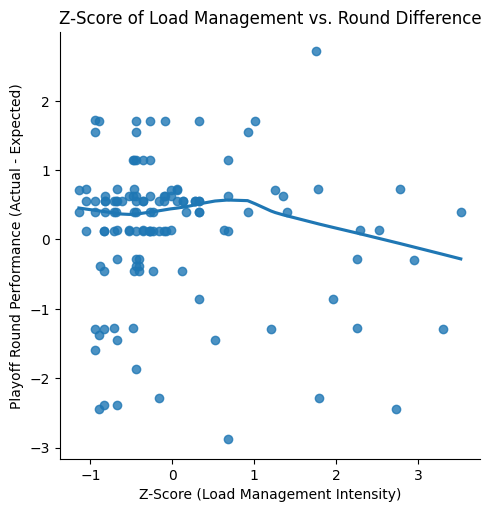

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lmplot(data=frame, x='Z_Score', y='Round_Diff', lowess=True)
plt.title("Z-Score of Load Management vs. Round Difference")
plt.xlabel("Z-Score (Load Management Intensity)")
plt.ylabel("Playoff Round Performance (Actual - Expected)")
plt.show()


C:\Users\tongf\AppData\Local\Temp\ipykernel_33912\641474112.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=frame, x='Quartile', y='Round_Diff', ci=95)


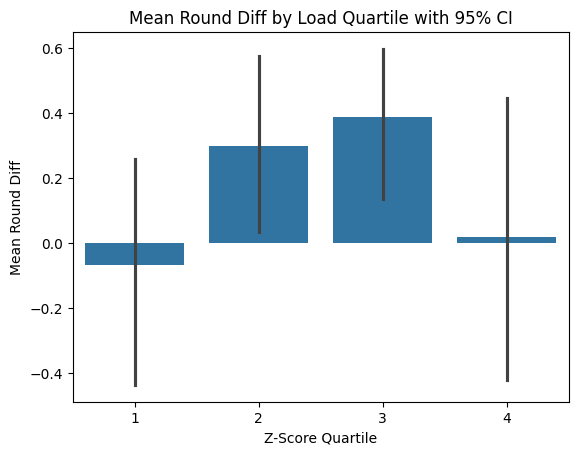

In [84]:
sns.barplot(data=frame, x='Quartile', y='Round_Diff', ci=95)
plt.title("Mean Round Diff by Load Quartile with 95% CI")
plt.xlabel("Z-Score Quartile")
plt.ylabel("Mean Round Diff")
plt.show()

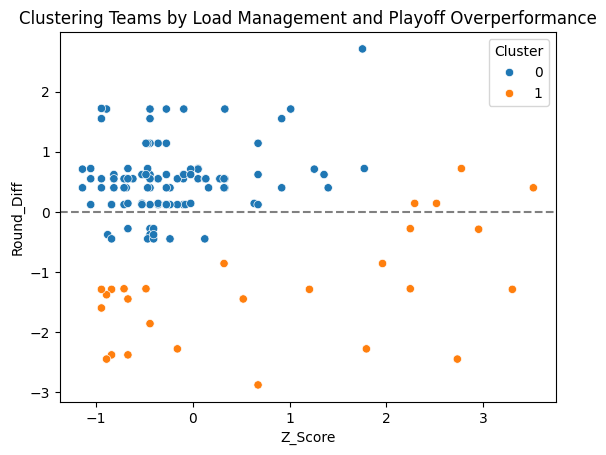

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

X = frame[['Z_Score', 'Round_Diff']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
frame['Cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(data=frame, x='Z_Score', y='Round_Diff', hue='Cluster', palette='tab10')
plt.title("Clustering Teams by Load Management and Playoff Overperformance")
plt.axhline(0, color='gray', linestyle='--')
plt.show()

In [92]:
frame.groupby('Cluster')[['Z_Score', 'Round_Diff']].mean()

,Z_Score,Round_Diff
Cluster,,
0,-0.223544,0.531584
1,0.836218,-1.286296


In [ ]:
'''
year_total_rest = {year : 0 for year in range(2017, 2025)}
team_total_rest = {team : 0 for team in data.keys()}

for team in data.keys():
    str_year, team_name = team.split('_')
    year = int(str_year)
    for player, days_rested in data[team]:
        year_total_rest[year] += days_rested
        team_total_rest[team] += days_rested
        
from collections import defaultdict
import numpy as np

yearly_team_rests = defaultdict(list)
team_year = {}

for team, total_rest in team_total_rest.items():
    str_year, _ = team.split('_')
    year = int(str_year)
    yearly_team_rests[year].append(total_rest)
    team_year[team] = year

team_rest_zscore = {}

for team, total_rest in team_total_rest.items():
    year = team_year[team]
    year_rests = yearly_team_rests[year]
    mean = np.mean(year_rests)
    std = np.std(year_rests)

    if std == 0:
        z = 0
    else:
        z = (total_rest - mean) / std

    team_rest_zscore[team] = z
'''